### Project 1 - Lending Club Loan Data Analysis 

For companies like Lending Club correctly predicting whether or not a loan will be a default is very important. In this project, using the historical data from 2007 to 2015, you have to build a deep learning model to predict the chance of default for future loans. As you will see later this dataset is highly imbalanced and includes a lot of features that makes this problem more challenging.

Objective: Create a model that predicts whether or not a loan will be default using the historical data.

###### 0. Import Libaries and Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df_loan_data = pd.read_csv('loan_data.csv')
df_loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
df_loan_data.shape

(9578, 14)

###### 1. Feature Transformation

In [4]:
df_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


No null value, but 1 categorical feature is observed

###### Transform categorical values into numerical values (discrete)

In [5]:
df_loan_data['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'all_other',
       'home_improvement', 'small_business', 'major_purchase',
       'educational'], dtype=object)

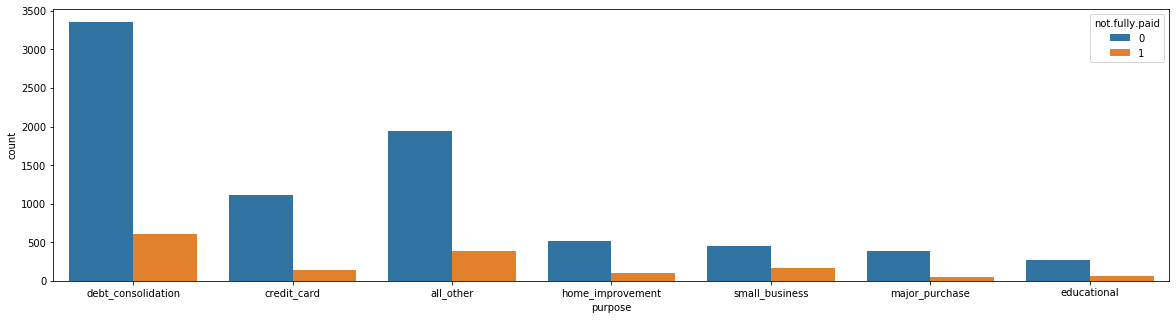

In [6]:
plt.figure(figsize=(20,5))
sns.countplot(x="purpose", hue="not.fully.paid", data=df_loan_data)
plt.show()

In [7]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = int)
df_loan_data['purpose'] = encoder.fit_transform(df_loan_data[['purpose']])
df_loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,2,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,2,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


###### 1. Exploratory data analysis

In [8]:
df_loan_data.describe()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,1.944038,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,1.686881,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,6.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [9]:
df_loan_data['not.fully.paid'].value_counts()

0    8045
1    1533
Name: not.fully.paid, dtype: int64

The target feature is a binary feature with 1533 out of 9578 loans indicating default 

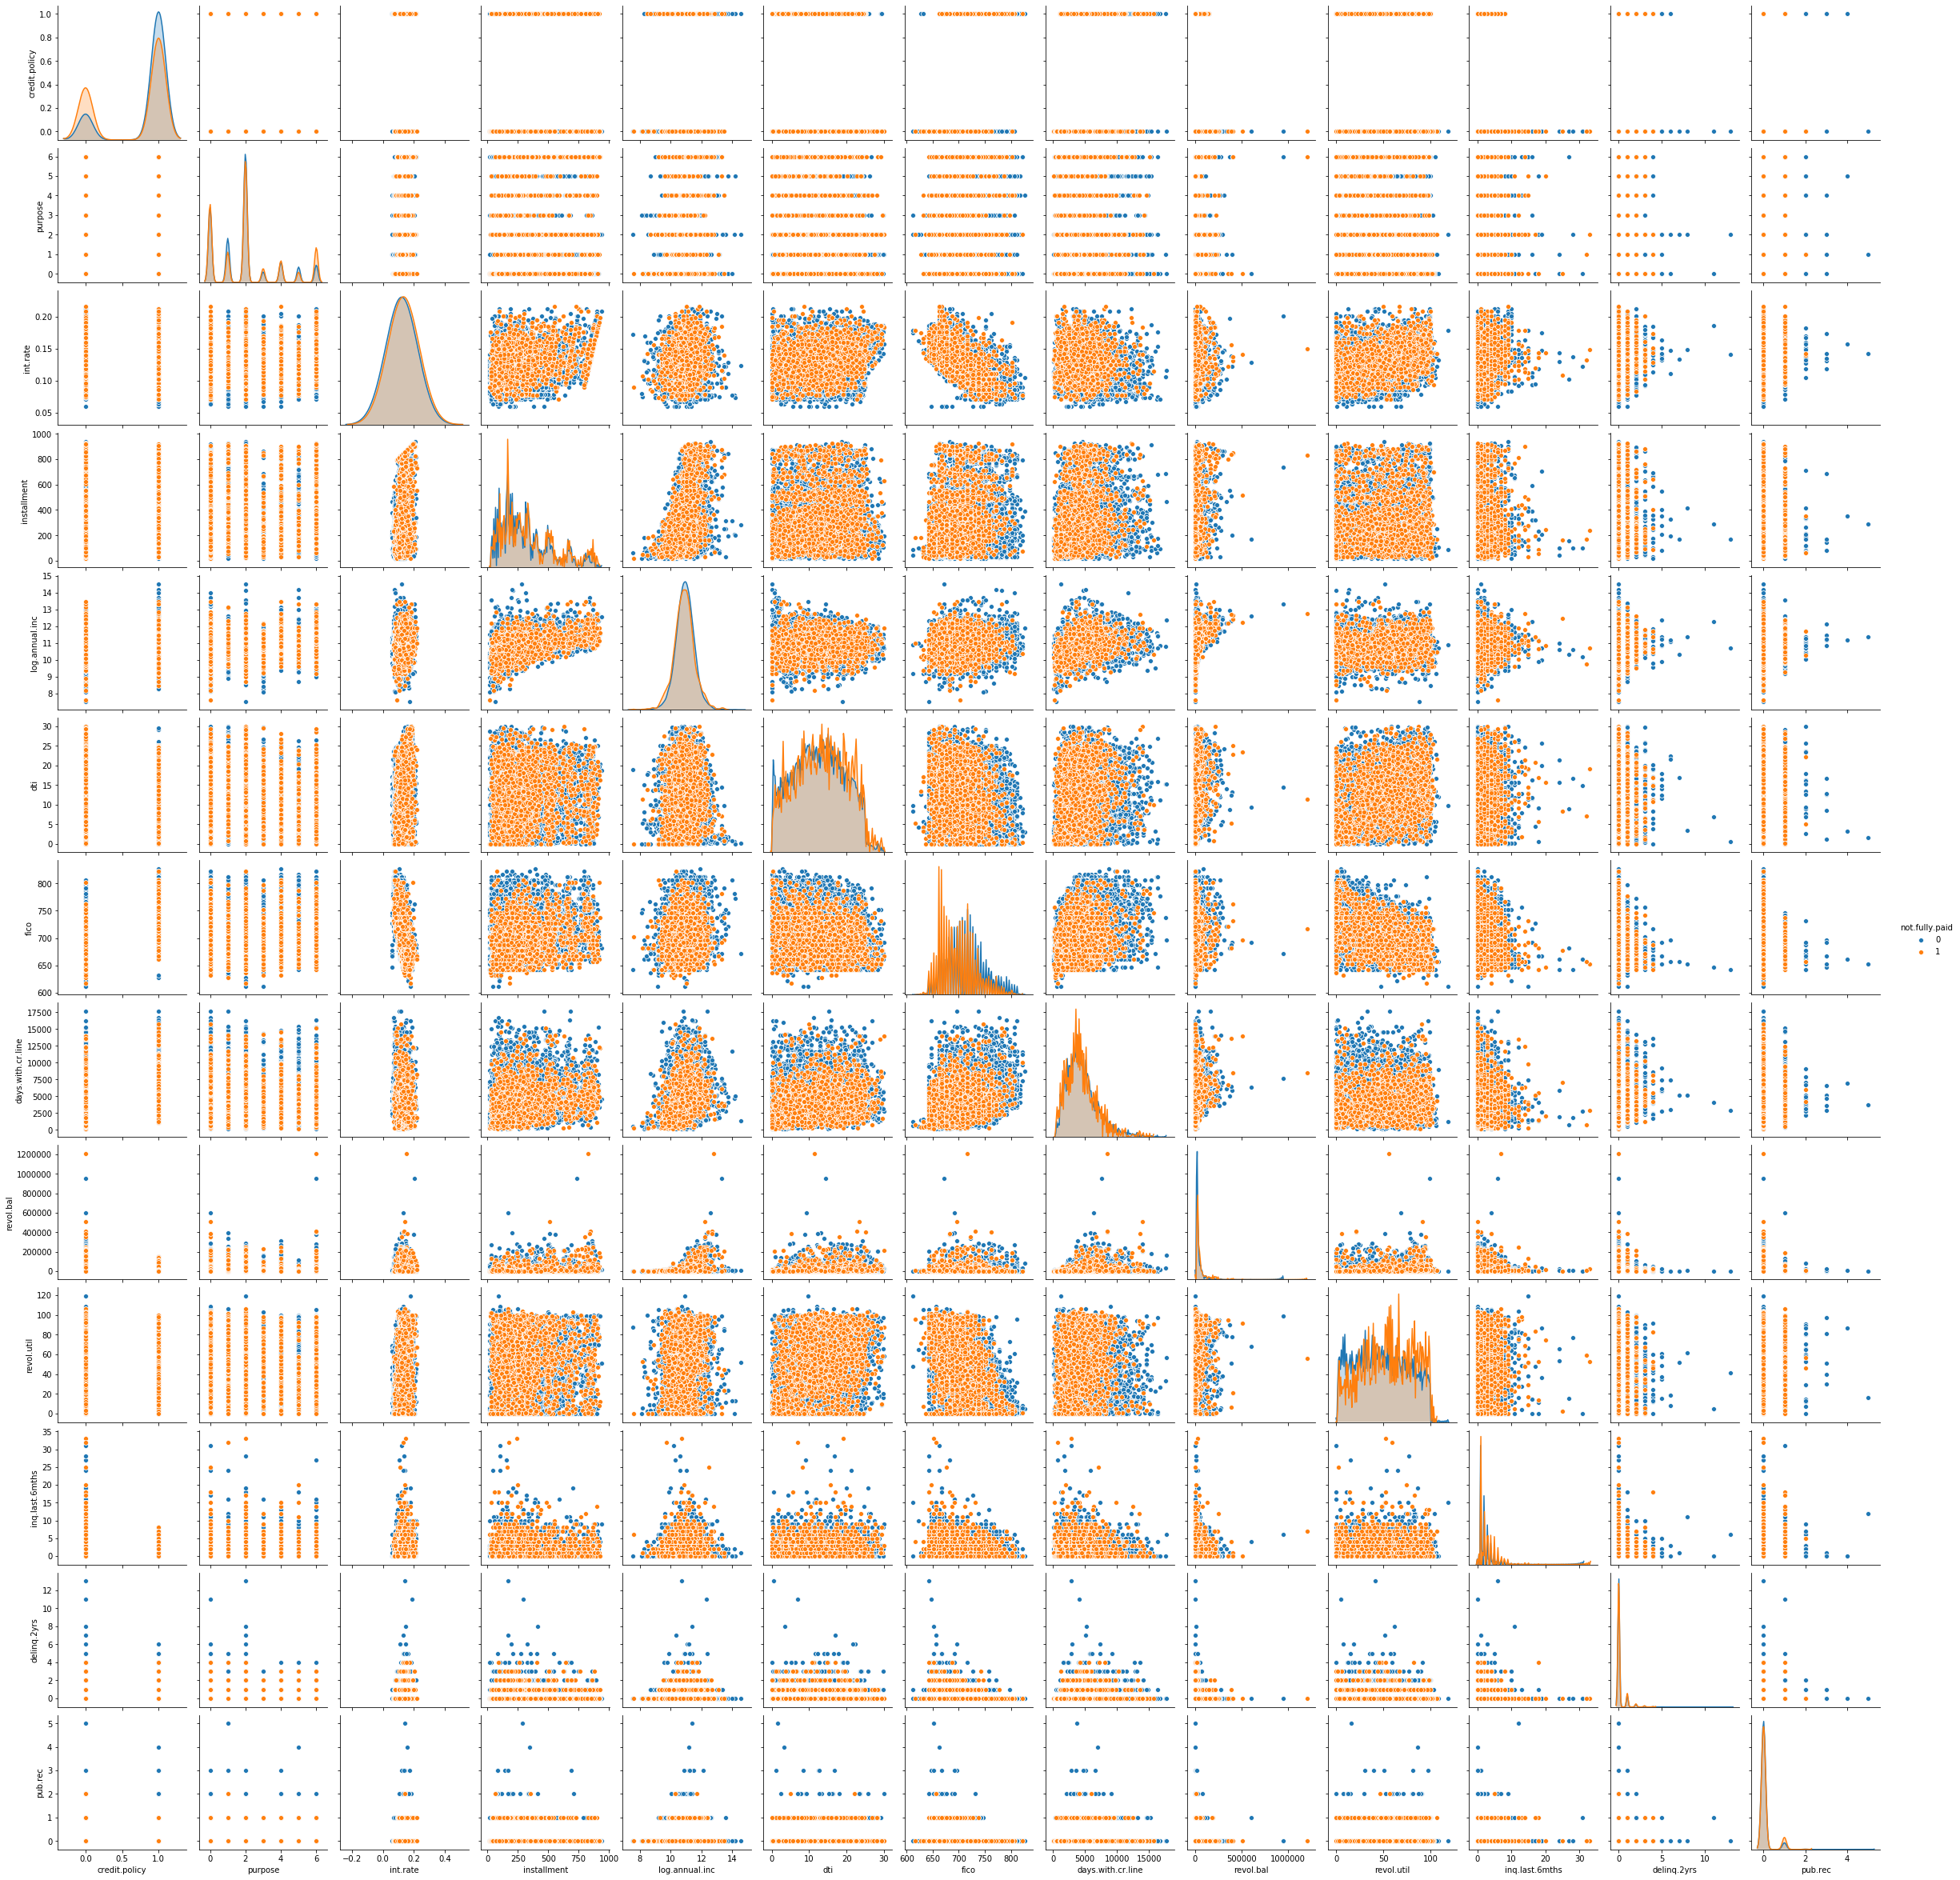

In [10]:
sns.pairplot(df_loan_data, diag_kind='kde', hue='not.fully.paid', diag_kws={'bw': 0.1})
plt.show()

While no easily observable relationship for most, features such as delinq.2yrs and pub.rec are worth further analysis

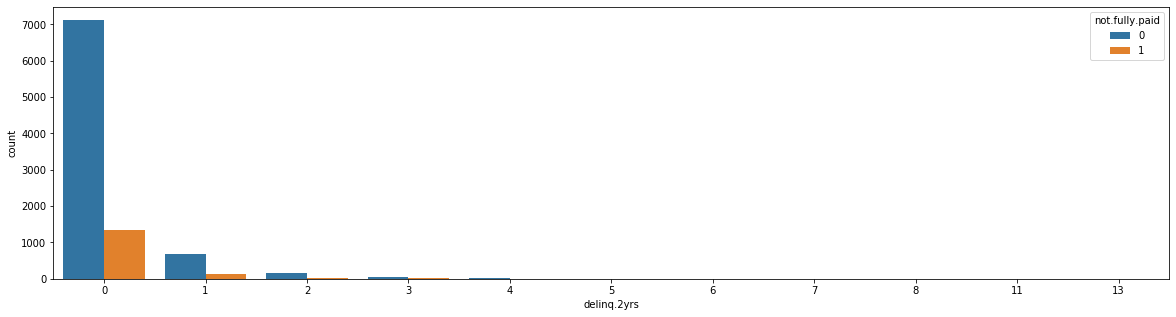

In [11]:
plt.figure(figsize=(20,5))
sns.countplot(x="delinq.2yrs", hue="not.fully.paid", data=df_loan_data)
plt.show()

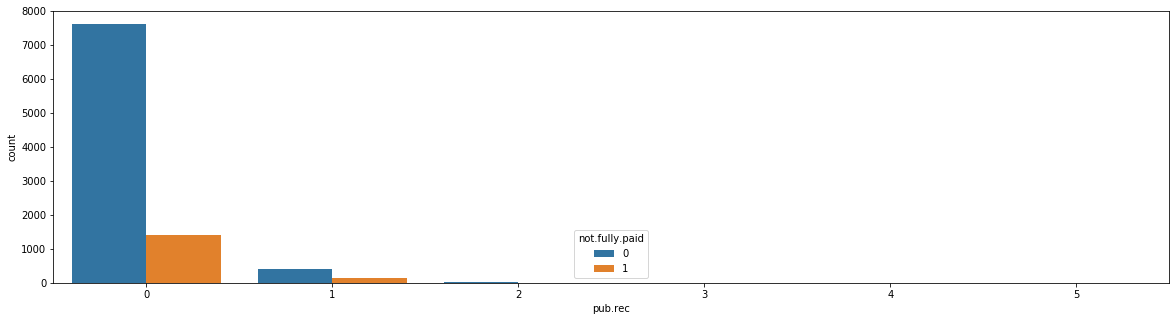

In [12]:
plt.figure(figsize=(20,5))
sns.countplot(x="pub.rec", hue="not.fully.paid", data=df_loan_data)
plt.show()

Despite that the defaults are falling within certain range of the feature values, there is no clear distinction from non defaults

###### 3. Additional Feature Engineering

###### Check the correlation between features 

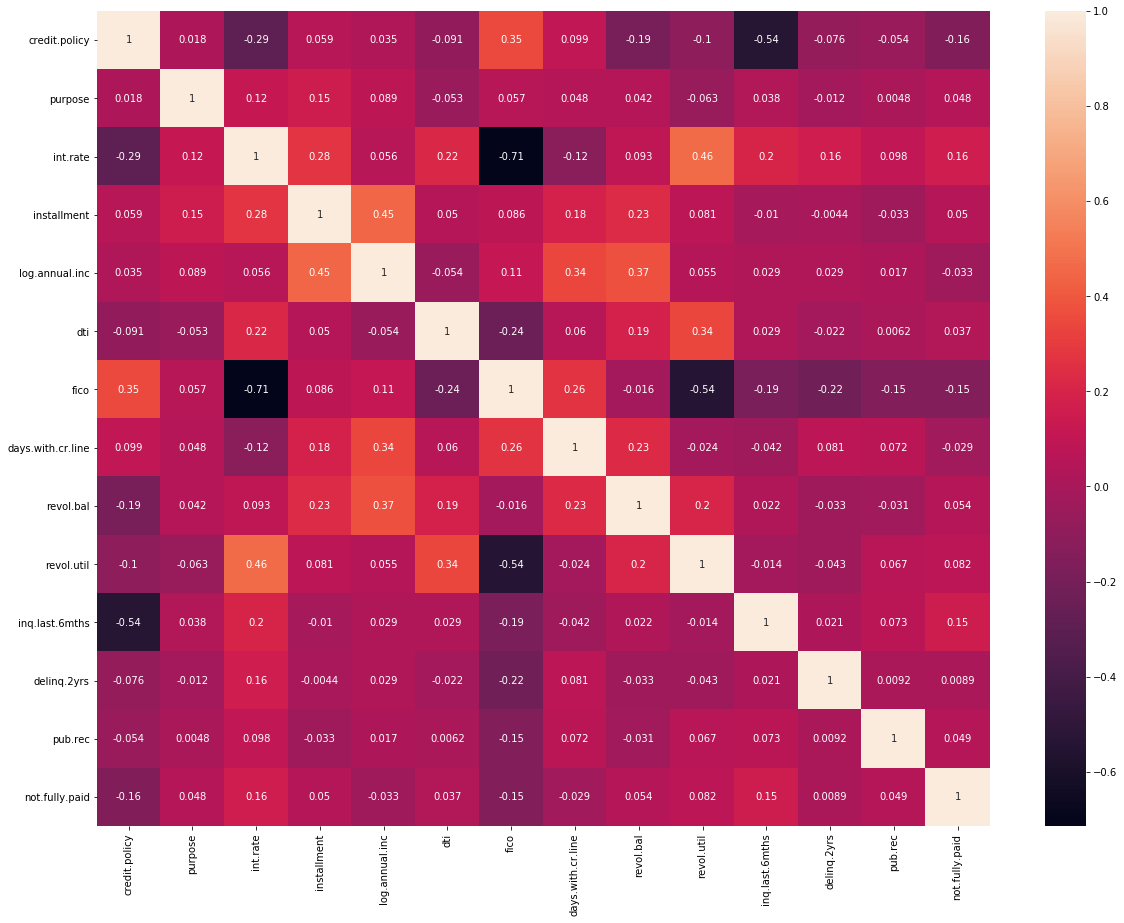

In [13]:
plt.figure(figsize = (20,15))
sns.heatmap(df_loan_data.corr(), annot=True)
plt.show()

###### Constructing a deep learning model using original data as a benchmark

In [14]:
df_y = df_loan_data['not.fully.paid']
df_x = df_loan_data.drop('not.fully.paid', axis=1)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=123)

In [15]:
model = Sequential()
model.add(Dense(13, input_dim=13, activation='relu'))
model.add(Dense(6, activation ='relu'))
model.add(Dense(3, activation ='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=5, verbose=1) 

Epoch 1/10
1341/1341 [==============================] - 2s 1ms/step - loss: 4.0489 - accuracy: 0.8088
Epoch 2/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.5045 - accuracy: 0.8429
Epoch 3/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4441 - accuracy: 0.8429
Epoch 4/10
1341/1341 [==============================] - 1s 989us/step - loss: 0.4435 - accuracy: 0.8429
Epoch 5/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4352 - accuracy: 0.8429
Epoch 6/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4349 - accuracy: 0.8429
Epoch 7/10
1341/1341 [==============================] - 1s 993us/step - loss: 0.4348 - accuracy: 0.8429
Epoch 8/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4349 - accuracy: 0.8429
Epoch 9/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4392 - accuracy: 0.8429
Epoch 10/10
1341/1341 [==============================] - 1s 993us/step - loss:

In [16]:
loss, accy = model.evaluate(x_test, y_test, verbose=0)
print('Loss: %.3f' % loss)
print('Accuracy: %.3f'  % accy)

Loss: 0.452
Accuracy: 0.833


###### Dropping interest rate which has a high correlation with fico and construct another model for comparison

In [17]:
df_y = df_loan_data['not.fully.paid']
df_x = df_loan_data.drop(['not.fully.paid', 'int.rate'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=123)

In [18]:
model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(6, activation ='relu'))
model.add(Dense(3, activation ='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=5, verbose=1) 

Epoch 1/10
1341/1341 [==============================] - 2s 973us/step - loss: 0.6351 - accuracy: 0.8401
Epoch 2/10
1341/1341 [==============================] - 1s 988us/step - loss: 0.4552 - accuracy: 0.8429
Epoch 3/10
1341/1341 [==============================] - 1s 965us/step - loss: 0.4377 - accuracy: 0.8429
Epoch 4/10
1341/1341 [==============================] - 1s 958us/step - loss: 0.4352 - accuracy: 0.8429
Epoch 5/10
1341/1341 [==============================] - 1s 955us/step - loss: 0.4349 - accuracy: 0.8429
Epoch 6/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4349 - accuracy: 0.8429
Epoch 7/10
1341/1341 [==============================] - 1s 989us/step - loss: 0.4348 - accuracy: 0.8429
Epoch 8/10
1341/1341 [==============================] - 1s 953us/step - loss: 0.4348 - accuracy: 0.8429
Epoch 9/10
1341/1341 [==============================] - 1s 962us/step - loss: 0.4349 - accuracy: 0.8429
Epoch 10/10
1341/1341 [==============================] - 1s 957us/

In [19]:
loss, accy = model.evaluate(x_test, y_test, verbose=0)
print('Loss: %.3f' % loss)
print('Accuracy: %.3f'  % accy)

Loss: 0.451
Accuracy: 0.833


###### Similar accuracy is achieved with the model using original data seems to be taking longer

###### 4. Modeling

###### Apply PCA to perform dimension reduction

In [20]:
df_y = df_loan_data['not.fully.paid']
df_x = df_loan_data.drop('not.fully.paid', axis=1)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=123)

sc = StandardScaler()
arr_x_train_scaled = sc.fit_transform(x_train)
arr_x_test_scaled = sc.transform(x_test)
pca = PCA().fit(arr_x_train_scaled)

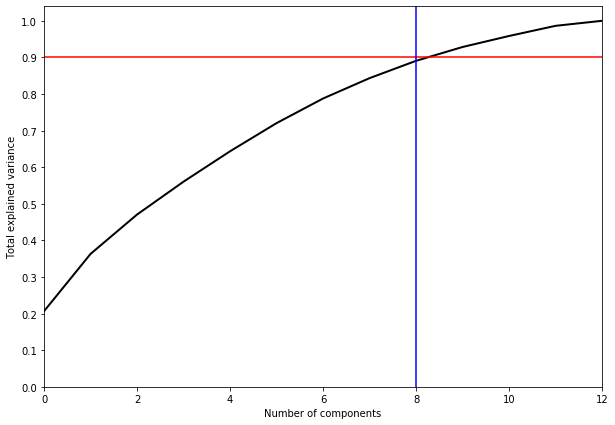

In [21]:
# Visualize Variance by new Dimensions
plt.figure(figsize=(10,7))

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)

plt.xlabel('Number of components')
plt.ylabel('Total explained variance')

plt.xlim(0, 12)
plt.yticks(np.arange(0, 1.1, 0.1))

plt.axhline(0.9, c='r')
plt.axvline(8, c='b')

plt.show()

###### 8 components are sufficient to explain close to 90% of the variance

In [22]:
pca = PCA(n_components = 8)
arr_x_train_pca = pca.fit_transform(arr_x_train_scaled)
arr_x_test_pca = pca.transform(arr_x_test_scaled)

df_x_train_pca = pd.DataFrame(arr_x_train_pca)
df_x_test_pca = pd.DataFrame(arr_x_test_pca)

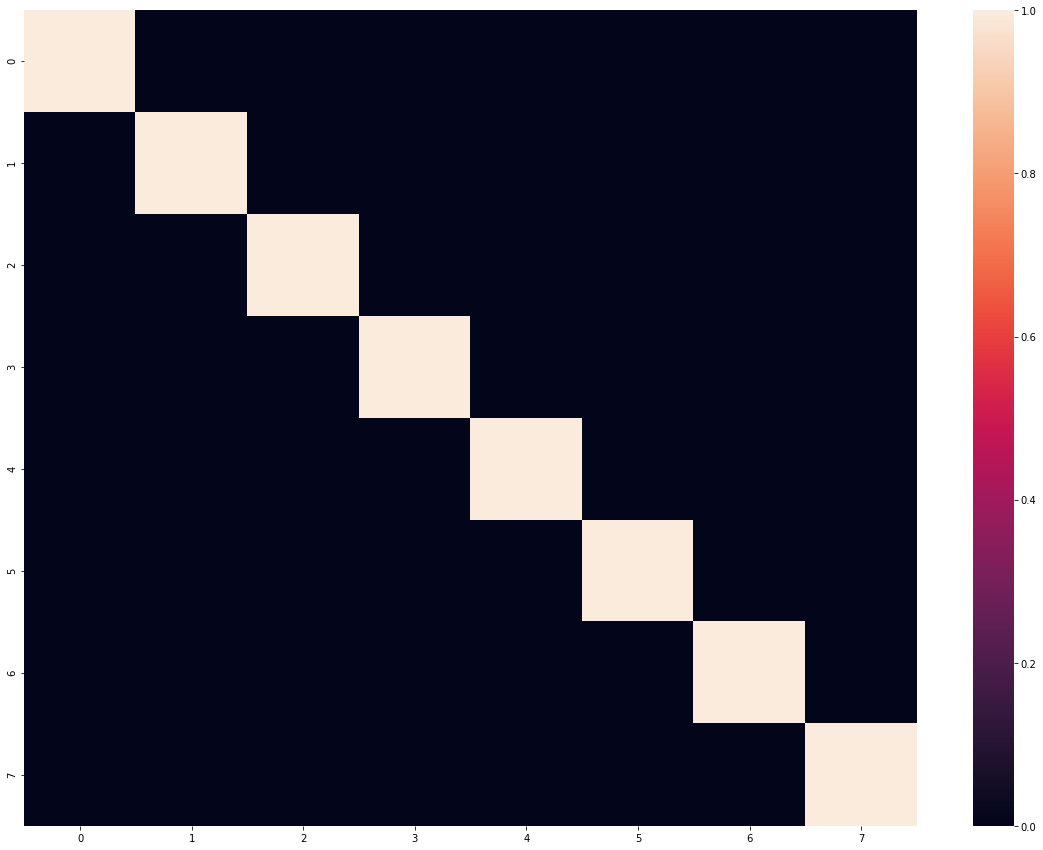

In [23]:
plt.figure(figsize = (20,15))
sns.heatmap(df_x_train_pca.corr())
plt.show()

###### Create a deep learning model using Keras with Tensorflow backend

In [24]:
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(4, activation ='relu'))
model.add(Dense(2, activation ='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(df_x_train_pca, y_train, epochs=10, batch_size=5, verbose=1) 

Epoch 1/10
1341/1341 [==============================] - 2s 978us/step - loss: 0.4613 - accuracy: 0.8429
Epoch 2/10
1341/1341 [==============================] - 1s 967us/step - loss: 0.4217 - accuracy: 0.8429
Epoch 3/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4163 - accuracy: 0.8429
Epoch 4/10
1341/1341 [==============================] - 1s 983us/step - loss: 0.4143 - accuracy: 0.8429
Epoch 5/10
1341/1341 [==============================] - 1s 967us/step - loss: 0.4120 - accuracy: 0.8429
Epoch 6/10
1341/1341 [==============================] - 1s 979us/step - loss: 0.4109 - accuracy: 0.8429
Epoch 7/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4104 - accuracy: 0.8429
Epoch 8/10
1341/1341 [==============================] - 1s 1ms/step - loss: 0.4088 - accuracy: 0.8429
Epoch 9/10
1341/1341 [==============================] - 1s 960us/step - loss: 0.4094 - accuracy: 0.8429
Epoch 10/10
1341/1341 [==============================] - 1s 995us/step

In [25]:
loss, accy = model.evaluate(df_x_test_pca, y_test, verbose=0)
print('Loss: %.3f' % loss)
print('Accuracy: %.3f'  % accy)

Loss: 0.429
Accuracy: 0.833


Same level of accuracy is achieved using data with reduced dimension